In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 0qzdskm4


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-0qzdskm4:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.7


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/659 [00:00<?, ?it/s]

  0%|                                                                      | 1/659 [00:00<06:33,  1.67it/s]

  1%|▋                                                                     | 6/659 [00:00<01:01, 10.61it/s]

  2%|█▏                                                                   | 11/659 [00:00<00:35, 18.32it/s]

  2%|█▋                                                                   | 16/659 [00:00<00:26, 24.36it/s]

  3%|██▏                                                                  | 21/659 [00:01<00:21, 29.55it/s]

  4%|██▋                                                                  | 26/659 [00:01<00:18, 33.42it/s]

  5%|███▏                                                                 | 31/659 [00:01<00:17, 36.31it/s]

  5%|███▊                                                                 | 36/659 [00:01<00:16, 38.26it/s]

  6%|████▎                                                                | 41/659 [00:01<00:15, 39.57it/s]

  7%|████▊                                                                | 46/659 [00:01<00:14, 40.97it/s]

  8%|█████▎                                                               | 51/659 [00:01<00:14, 41.58it/s]

  8%|█████▊                                                               | 56/659 [00:01<00:14, 42.39it/s]

  9%|██████▍                                                              | 61/659 [00:01<00:14, 42.68it/s]

 10%|██████▉                                                              | 66/659 [00:02<00:13, 43.10it/s]

 11%|███████▍                                                             | 71/659 [00:02<00:13, 43.57it/s]

 12%|███████▉                                                             | 76/659 [00:02<00:13, 43.55it/s]

 12%|████████▍                                                            | 81/659 [00:02<00:13, 43.81it/s]

 13%|█████████                                                            | 86/659 [00:02<00:13, 43.69it/s]

 14%|█████████▌                                                           | 91/659 [00:02<00:12, 44.15it/s]

 15%|██████████                                                           | 96/659 [00:02<00:12, 44.40it/s]

 15%|██████████▍                                                         | 101/659 [00:02<00:12, 44.17it/s]

 16%|██████████▉                                                         | 106/659 [00:02<00:12, 44.26it/s]

 17%|███████████▍                                                        | 111/659 [00:03<00:12, 44.59it/s]

 18%|███████████▉                                                        | 116/659 [00:03<00:12, 44.85it/s]

 18%|████████████▍                                                       | 121/659 [00:03<00:12, 44.70it/s]

 19%|█████████████                                                       | 126/659 [00:03<00:12, 44.28it/s]

 20%|█████████████▌                                                      | 131/659 [00:03<00:11, 44.56it/s]

 21%|██████████████                                                      | 136/659 [00:03<00:11, 44.33it/s]

 21%|██████████████▌                                                     | 141/659 [00:03<00:11, 44.12it/s]

 22%|███████████████                                                     | 146/659 [00:03<00:11, 44.04it/s]

 23%|███████████████▌                                                    | 151/659 [00:04<00:11, 44.39it/s]

 24%|████████████████                                                    | 156/659 [00:04<00:11, 44.73it/s]

 24%|████████████████▌                                                   | 161/659 [00:04<00:11, 44.72it/s]

 25%|█████████████████▏                                                  | 166/659 [00:04<00:11, 44.65it/s]

 26%|█████████████████▋                                                  | 171/659 [00:04<00:10, 44.39it/s]

 27%|██████████████████▏                                                 | 176/659 [00:04<00:10, 44.62it/s]

 27%|██████████████████▋                                                 | 181/659 [00:04<00:10, 44.55it/s]

 28%|███████████████████▏                                                | 186/659 [00:04<00:10, 44.57it/s]

 29%|███████████████████▋                                                | 191/659 [00:04<00:10, 44.22it/s]

 30%|████████████████████▏                                               | 196/659 [00:05<00:10, 44.54it/s]

 31%|████████████████████▋                                               | 201/659 [00:05<00:10, 44.89it/s]

 31%|█████████████████████▎                                              | 206/659 [00:05<00:10, 45.00it/s]

 32%|█████████████████████▊                                              | 211/659 [00:05<00:10, 44.64it/s]

 33%|██████████████████████▎                                             | 216/659 [00:05<00:09, 44.50it/s]

 34%|██████████████████████▊                                             | 221/659 [00:05<00:09, 44.46it/s]

 34%|███████████████████████▎                                            | 226/659 [00:05<00:09, 44.16it/s]

 35%|███████████████████████▊                                            | 231/659 [00:05<00:09, 44.21it/s]

 36%|████████████████████████▎                                           | 236/659 [00:05<00:09, 44.09it/s]

 37%|████████████████████████▊                                           | 241/659 [00:06<00:09, 44.35it/s]

 37%|█████████████████████████▍                                          | 246/659 [00:06<00:09, 44.79it/s]

 38%|█████████████████████████▉                                          | 251/659 [00:06<00:09, 45.15it/s]

 39%|██████████████████████████▍                                         | 256/659 [00:06<00:08, 45.10it/s]

 40%|██████████████████████████▉                                         | 261/659 [00:06<00:08, 44.88it/s]

 40%|███████████████████████████▍                                        | 266/659 [00:06<00:08, 44.35it/s]

 41%|███████████████████████████▉                                        | 271/659 [00:06<00:08, 44.63it/s]

 42%|████████████████████████████▍                                       | 276/659 [00:06<00:08, 44.80it/s]

 43%|████████████████████████████▉                                       | 281/659 [00:06<00:08, 45.27it/s]

 43%|█████████████████████████████▌                                      | 286/659 [00:07<00:08, 45.50it/s]

 44%|██████████████████████████████                                      | 291/659 [00:07<00:08, 45.67it/s]

 45%|██████████████████████████████▌                                     | 296/659 [00:07<00:07, 45.79it/s]

 46%|███████████████████████████████                                     | 301/659 [00:07<00:07, 45.75it/s]

 46%|███████████████████████████████▌                                    | 306/659 [00:07<00:07, 45.35it/s]

 47%|████████████████████████████████                                    | 311/659 [00:07<00:07, 45.60it/s]

 48%|████████████████████████████████▌                                   | 316/659 [00:07<00:07, 45.48it/s]

 49%|█████████████████████████████████                                   | 321/659 [00:07<00:07, 45.60it/s]

 49%|█████████████████████████████████▋                                  | 326/659 [00:07<00:07, 44.67it/s]

 50%|██████████████████████████████████▏                                 | 331/659 [00:08<00:07, 44.58it/s]

 51%|██████████████████████████████████▋                                 | 336/659 [00:08<00:07, 44.37it/s]

 52%|███████████████████████████████████▏                                | 341/659 [00:08<00:07, 44.37it/s]

 53%|███████████████████████████████████▋                                | 346/659 [00:08<00:07, 43.88it/s]

 53%|████████████████████████████████████▏                               | 351/659 [00:08<00:07, 43.81it/s]

 54%|████████████████████████████████████▋                               | 356/659 [00:08<00:06, 43.84it/s]

 55%|█████████████████████████████████████▎                              | 361/659 [00:08<00:06, 44.12it/s]

 56%|█████████████████████████████████████▊                              | 366/659 [00:08<00:06, 44.26it/s]

 56%|██████████████████████████████████████▎                             | 371/659 [00:08<00:06, 43.76it/s]

 57%|██████████████████████████████████████▊                             | 376/659 [00:09<00:06, 44.11it/s]

 58%|███████████████████████████████████████▎                            | 381/659 [00:09<00:06, 44.21it/s]

 59%|███████████████████████████████████████▊                            | 386/659 [00:09<00:06, 43.96it/s]

 59%|████████████████████████████████████████▎                           | 391/659 [00:09<00:06, 43.67it/s]

 60%|████████████████████████████████████████▊                           | 396/659 [00:09<00:05, 43.92it/s]

 61%|█████████████████████████████████████████▍                          | 401/659 [00:09<00:05, 44.35it/s]

 62%|█████████████████████████████████████████▉                          | 406/659 [00:09<00:05, 44.65it/s]

 62%|██████████████████████████████████████████▍                         | 411/659 [00:09<00:05, 44.51it/s]

 63%|██████████████████████████████████████████▉                         | 416/659 [00:09<00:05, 44.05it/s]

 64%|███████████████████████████████████████████▍                        | 421/659 [00:10<00:05, 44.40it/s]

 65%|███████████████████████████████████████████▉                        | 426/659 [00:10<00:05, 43.86it/s]

 65%|████████████████████████████████████████████▍                       | 431/659 [00:10<00:05, 44.04it/s]

 66%|████████████████████████████████████████████▉                       | 436/659 [00:10<00:05, 43.88it/s]

 67%|█████████████████████████████████████████████▌                      | 441/659 [00:10<00:04, 44.11it/s]

 68%|██████████████████████████████████████████████                      | 446/659 [00:10<00:04, 44.12it/s]

 68%|██████████████████████████████████████████████▌                     | 451/659 [00:10<00:04, 44.10it/s]

 69%|███████████████████████████████████████████████                     | 456/659 [00:10<00:04, 44.10it/s]

 70%|███████████████████████████████████████████████▌                    | 461/659 [00:10<00:04, 43.92it/s]

 71%|████████████████████████████████████████████████                    | 466/659 [00:11<00:04, 44.04it/s]

 71%|████████████████████████████████████████████████▌                   | 471/659 [00:11<00:04, 43.88it/s]

 72%|█████████████████████████████████████████████████                   | 476/659 [00:11<00:04, 44.03it/s]

 73%|█████████████████████████████████████████████████▋                  | 481/659 [00:11<00:04, 44.38it/s]

 74%|██████████████████████████████████████████████████▏                 | 486/659 [00:11<00:03, 44.62it/s]

 75%|██████████████████████████████████████████████████▋                 | 491/659 [00:11<00:03, 44.87it/s]

 75%|███████████████████████████████████████████████████▏                | 496/659 [00:11<00:03, 44.42it/s]

 76%|███████████████████████████████████████████████████▋                | 501/659 [00:11<00:03, 44.45it/s]

 77%|████████████████████████████████████████████████████▏               | 506/659 [00:11<00:03, 44.31it/s]

 78%|████████████████████████████████████████████████████▋               | 511/659 [00:12<00:03, 44.29it/s]

 78%|█████████████████████████████████████████████████████▏              | 516/659 [00:12<00:03, 44.44it/s]

 79%|█████████████████████████████████████████████████████▊              | 521/659 [00:12<00:03, 44.55it/s]

 80%|██████████████████████████████████████████████████████▎             | 526/659 [00:12<00:02, 44.48it/s]

 81%|██████████████████████████████████████████████████████▊             | 531/659 [00:12<00:02, 44.55it/s]

 81%|███████████████████████████████████████████████████████▎            | 536/659 [00:12<00:02, 44.91it/s]

 82%|███████████████████████████████████████████████████████▊            | 541/659 [00:12<00:02, 45.14it/s]

 83%|████████████████████████████████████████████████████████▎           | 546/659 [00:12<00:02, 45.14it/s]

 84%|████████████████████████████████████████████████████████▊           | 551/659 [00:12<00:02, 44.66it/s]

 84%|█████████████████████████████████████████████████████████▎          | 556/659 [00:13<00:02, 44.81it/s]

 85%|█████████████████████████████████████████████████████████▉          | 561/659 [00:13<00:02, 44.76it/s]

 86%|██████████████████████████████████████████████████████████▍         | 566/659 [00:13<00:02, 44.93it/s]

 87%|██████████████████████████████████████████████████████████▉         | 571/659 [00:13<00:01, 45.00it/s]

 87%|███████████████████████████████████████████████████████████▍        | 576/659 [00:13<00:01, 44.90it/s]

 88%|███████████████████████████████████████████████████████████▉        | 581/659 [00:13<00:01, 45.25it/s]

 89%|████████████████████████████████████████████████████████████▍       | 586/659 [00:13<00:01, 45.48it/s]

 90%|████████████████████████████████████████████████████████████▉       | 591/659 [00:13<00:01, 45.37it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 596/659 [00:13<00:01, 45.08it/s]

 91%|██████████████████████████████████████████████████████████████      | 601/659 [00:14<00:01, 45.40it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 606/659 [00:14<00:01, 45.58it/s]

 93%|███████████████████████████████████████████████████████████████     | 611/659 [00:14<00:01, 45.73it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 616/659 [00:14<00:00, 45.84it/s]

 94%|████████████████████████████████████████████████████████████████    | 621/659 [00:14<00:00, 45.80it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 626/659 [00:14<00:00, 45.13it/s]

 96%|█████████████████████████████████████████████████████████████████   | 631/659 [00:14<00:00, 45.19it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 636/659 [00:14<00:00, 45.18it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 641/659 [00:14<00:00, 44.93it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 646/659 [00:15<00:00, 44.98it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 651/659 [00:15<00:00, 44.83it/s]

100%|███████████████████████████████████████████████████████████████████▋| 656/659 [00:15<00:00, 45.22it/s]

100%|████████████████████████████████████████████████████████████████████| 659/659 [00:15<00:00, 42.73it/s]

train - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:09,  8.76it/s]

  7%|█████▏                                                                 | 6/83 [00:00<00:02, 29.07it/s]

 13%|█████████▎                                                            | 11/83 [00:00<00:02, 35.61it/s]

 19%|█████████████▍                                                        | 16/83 [00:00<00:01, 39.05it/s]

 25%|█████████████████▋                                                    | 21/83 [00:00<00:01, 40.65it/s]

 31%|█████████████████████▉                                                | 26/83 [00:00<00:01, 41.91it/s]

 37%|██████████████████████████▏                                           | 31/83 [00:00<00:01, 42.47it/s]

 43%|██████████████████████████████▎                                       | 36/83 [00:00<00:01, 43.32it/s]

 49%|██████████████████████████████████▌                                   | 41/83 [00:01<00:00, 44.01it/s]

 55%|██████████████████████████████████████▊                               | 46/83 [00:01<00:00, 43.59it/s]

 61%|███████████████████████████████████████████                           | 51/83 [00:01<00:00, 44.11it/s]

 67%|███████████████████████████████████████████████▏                      | 56/83 [00:01<00:00, 44.11it/s]

 73%|███████████████████████████████████████████████████▍                  | 61/83 [00:01<00:00, 44.21it/s]

 80%|███████████████████████████████████████████████████████▋              | 66/83 [00:01<00:00, 44.19it/s]

 86%|███████████████████████████████████████████████████████████▉          | 71/83 [00:01<00:00, 44.50it/s]

 92%|████████████████████████████████████████████████████████████████      | 76/83 [00:01<00:00, 44.38it/s]

 98%|████████████████████████████████████████████████████████████████████▎ | 81/83 [00:01<00:00, 44.34it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.84it/s]

val - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:10,  8.13it/s]

  7%|█████▏                                                                 | 6/83 [00:00<00:02, 28.42it/s]

 13%|█████████▎                                                            | 11/83 [00:00<00:02, 35.31it/s]

 19%|█████████████▍                                                        | 16/83 [00:00<00:01, 38.95it/s]

 25%|█████████████████▋                                                    | 21/83 [00:00<00:01, 40.67it/s]

 31%|█████████████████████▉                                                | 26/83 [00:00<00:01, 41.91it/s]

 37%|██████████████████████████▏                                           | 31/83 [00:00<00:01, 42.37it/s]

 43%|██████████████████████████████▎                                       | 36/83 [00:00<00:01, 43.26it/s]

 49%|██████████████████████████████████▌                                   | 41/83 [00:01<00:00, 43.65it/s]

 55%|██████████████████████████████████████▊                               | 46/83 [00:01<00:00, 43.87it/s]

 61%|███████████████████████████████████████████                           | 51/83 [00:01<00:00, 43.84it/s]

 67%|███████████████████████████████████████████████▏                      | 56/83 [00:01<00:00, 44.23it/s]

 73%|███████████████████████████████████████████████████▍                  | 61/83 [00:01<00:00, 44.64it/s]

 80%|███████████████████████████████████████████████████████▋              | 66/83 [00:01<00:00, 44.80it/s]

 86%|███████████████████████████████████████████████████████████▉          | 71/83 [00:01<00:00, 44.44it/s]

 92%|████████████████████████████████████████████████████████████████      | 76/83 [00:01<00:00, 44.12it/s]

 98%|████████████████████████████████████████████████████████████████████▎ | 81/83 [00:01<00:00, 44.44it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.73it/s]

test InD - OK


  0%|                                                                              | 0/680 [00:00<?, ?it/s]

  0%|                                                                      | 1/680 [00:00<01:26,  7.84it/s]

  1%|▌                                                                     | 6/680 [00:00<00:24, 27.84it/s]

  2%|█                                                                    | 11/680 [00:00<00:19, 35.12it/s]

  2%|█▌                                                                   | 16/680 [00:00<00:17, 38.71it/s]

  3%|██▏                                                                  | 21/680 [00:00<00:16, 40.99it/s]

  4%|██▋                                                                  | 26/680 [00:00<00:15, 41.99it/s]

  5%|███▏                                                                 | 31/680 [00:00<00:15, 43.04it/s]

  5%|███▋                                                                 | 36/680 [00:00<00:14, 43.79it/s]

  6%|████▏                                                                | 41/680 [00:01<00:14, 43.93it/s]

  7%|████▋                                                                | 46/680 [00:01<00:14, 44.29it/s]

  8%|█████▏                                                               | 51/680 [00:01<00:14, 44.28it/s]

  8%|█████▋                                                               | 56/680 [00:01<00:14, 44.31it/s]

  9%|██████▏                                                              | 61/680 [00:01<00:13, 44.26it/s]

 10%|██████▋                                                              | 66/680 [00:01<00:13, 44.06it/s]

 10%|███████▏                                                             | 71/680 [00:01<00:13, 44.14it/s]

 11%|███████▋                                                             | 76/680 [00:01<00:13, 43.79it/s]

 12%|████████▏                                                            | 81/680 [00:01<00:13, 44.12it/s]

 13%|████████▋                                                            | 86/680 [00:02<00:13, 43.78it/s]

 13%|█████████▏                                                           | 91/680 [00:02<00:13, 43.97it/s]

 14%|█████████▋                                                           | 96/680 [00:02<00:13, 44.01it/s]

 15%|██████████                                                          | 101/680 [00:02<00:13, 44.29it/s]

 16%|██████████▌                                                         | 106/680 [00:02<00:13, 43.80it/s]

 16%|███████████                                                         | 111/680 [00:02<00:13, 43.68it/s]

 17%|███████████▌                                                        | 116/680 [00:02<00:12, 43.81it/s]

 18%|████████████                                                        | 121/680 [00:02<00:12, 43.91it/s]

 19%|████████████▌                                                       | 126/680 [00:02<00:12, 43.86it/s]

 19%|█████████████                                                       | 131/680 [00:03<00:12, 44.50it/s]

 20%|█████████████▌                                                      | 136/680 [00:03<00:12, 44.21it/s]

 21%|██████████████                                                      | 141/680 [00:03<00:12, 44.22it/s]

 21%|██████████████▌                                                     | 146/680 [00:03<00:11, 44.53it/s]

 22%|███████████████                                                     | 151/680 [00:03<00:11, 44.37it/s]

 23%|███████████████▌                                                    | 156/680 [00:03<00:11, 44.40it/s]

 24%|████████████████                                                    | 161/680 [00:03<00:11, 44.71it/s]

 24%|████████████████▌                                                   | 166/680 [00:03<00:11, 44.50it/s]

 25%|█████████████████                                                   | 171/680 [00:03<00:11, 44.89it/s]

 26%|█████████████████▌                                                  | 176/680 [00:04<00:11, 44.74it/s]

 27%|██████████████████                                                  | 181/680 [00:04<00:11, 44.60it/s]

 27%|██████████████████▌                                                 | 186/680 [00:04<00:10, 44.94it/s]

 28%|███████████████████                                                 | 191/680 [00:04<00:10, 45.06it/s]

 29%|███████████████████▌                                                | 196/680 [00:04<00:10, 44.84it/s]

 30%|████████████████████                                                | 201/680 [00:04<00:10, 44.97it/s]

 30%|████████████████████▌                                               | 206/680 [00:04<00:10, 44.56it/s]

 31%|█████████████████████                                               | 211/680 [00:04<00:10, 44.78it/s]

 32%|█████████████████████▌                                              | 216/680 [00:04<00:10, 45.03it/s]

 32%|██████████████████████                                              | 221/680 [00:05<00:10, 44.44it/s]

 33%|██████████████████████▌                                             | 226/680 [00:05<00:10, 44.65it/s]

 34%|███████████████████████                                             | 231/680 [00:05<00:10, 44.78it/s]

 35%|███████████████████████▌                                            | 236/680 [00:05<00:09, 44.54it/s]

 35%|████████████████████████                                            | 241/680 [00:05<00:09, 44.89it/s]

 36%|████████████████████████▌                                           | 246/680 [00:05<00:09, 45.25it/s]

 37%|█████████████████████████                                           | 251/680 [00:05<00:09, 45.05it/s]

 38%|█████████████████████████▌                                          | 256/680 [00:05<00:09, 45.10it/s]

 38%|██████████████████████████                                          | 261/680 [00:05<00:09, 45.13it/s]

 39%|██████████████████████████▌                                         | 266/680 [00:06<00:09, 44.64it/s]

 40%|███████████████████████████                                         | 271/680 [00:06<00:09, 44.94it/s]

 41%|███████████████████████████▌                                        | 276/680 [00:06<00:08, 45.01it/s]

 41%|████████████████████████████                                        | 281/680 [00:06<00:08, 44.55it/s]

 42%|████████████████████████████▌                                       | 286/680 [00:06<00:08, 44.86it/s]

 43%|█████████████████████████████                                       | 291/680 [00:06<00:08, 45.04it/s]

 44%|█████████████████████████████▌                                      | 296/680 [00:06<00:08, 45.58it/s]

 44%|██████████████████████████████                                      | 301/680 [00:06<00:08, 44.98it/s]

 45%|██████████████████████████████▌                                     | 306/680 [00:06<00:08, 45.04it/s]

 46%|███████████████████████████████                                     | 311/680 [00:07<00:08, 45.09it/s]

 46%|███████████████████████████████▌                                    | 316/680 [00:07<00:08, 44.65it/s]

 47%|████████████████████████████████                                    | 321/680 [00:07<00:07, 45.01it/s]

 48%|████████████████████████████████▌                                   | 326/680 [00:07<00:07, 44.94it/s]

 49%|█████████████████████████████████                                   | 331/680 [00:07<00:07, 45.16it/s]

 49%|█████████████████████████████████▌                                  | 336/680 [00:07<00:07, 45.33it/s]

 50%|██████████████████████████████████                                  | 341/680 [00:07<00:07, 45.34it/s]

 51%|██████████████████████████████████▌                                 | 346/680 [00:07<00:07, 45.38it/s]

 52%|███████████████████████████████████                                 | 351/680 [00:07<00:07, 45.25it/s]

 52%|███████████████████████████████████▌                                | 356/680 [00:08<00:07, 45.76it/s]

 53%|████████████████████████████████████                                | 361/680 [00:08<00:06, 45.66it/s]

 54%|████████████████████████████████████▌                               | 366/680 [00:08<00:06, 45.74it/s]

 55%|█████████████████████████████████████                               | 371/680 [00:08<00:06, 45.76it/s]

 55%|█████████████████████████████████████▌                              | 376/680 [00:08<00:06, 45.57it/s]

 56%|██████████████████████████████████████                              | 381/680 [00:08<00:06, 45.95it/s]

 57%|██████████████████████████████████████▌                             | 386/680 [00:08<00:06, 45.42it/s]

 57%|███████████████████████████████████████                             | 391/680 [00:08<00:06, 45.35it/s]

 58%|███████████████████████████████████████▌                            | 396/680 [00:08<00:06, 44.55it/s]

 59%|████████████████████████████████████████                            | 401/680 [00:09<00:06, 44.78it/s]

 60%|████████████████████████████████████████▌                           | 406/680 [00:09<00:06, 44.29it/s]

 60%|█████████████████████████████████████████                           | 411/680 [00:09<00:06, 44.44it/s]

 61%|█████████████████████████████████████████▌                          | 416/680 [00:09<00:05, 44.46it/s]

 62%|██████████████████████████████████████████                          | 421/680 [00:09<00:05, 44.93it/s]

 63%|██████████████████████████████████████████▌                         | 426/680 [00:09<00:05, 44.98it/s]

 63%|███████████████████████████████████████████                         | 431/680 [00:09<00:05, 45.12it/s]

 64%|███████████████████████████████████████████▌                        | 436/680 [00:09<00:05, 45.18it/s]

 65%|████████████████████████████████████████████                        | 441/680 [00:09<00:05, 44.74it/s]

 66%|████████████████████████████████████████████▌                       | 446/680 [00:10<00:05, 44.63it/s]

 66%|█████████████████████████████████████████████                       | 451/680 [00:10<00:05, 44.31it/s]

 67%|█████████████████████████████████████████████▌                      | 456/680 [00:10<00:05, 44.14it/s]

 68%|██████████████████████████████████████████████                      | 461/680 [00:10<00:04, 44.69it/s]

 69%|██████████████████████████████████████████████▌                     | 466/680 [00:10<00:04, 44.76it/s]

 69%|███████████████████████████████████████████████                     | 471/680 [00:10<00:04, 44.72it/s]

 70%|███████████████████████████████████████████████▌                    | 476/680 [00:10<00:04, 45.01it/s]

 71%|████████████████████████████████████████████████                    | 481/680 [00:10<00:04, 45.09it/s]

 71%|████████████████████████████████████████████████▌                   | 486/680 [00:10<00:04, 45.29it/s]

 72%|█████████████████████████████████████████████████                   | 491/680 [00:11<00:04, 45.26it/s]

 73%|█████████████████████████████████████████████████▌                  | 496/680 [00:11<00:04, 45.79it/s]

 74%|██████████████████████████████████████████████████                  | 501/680 [00:11<00:03, 45.55it/s]

 74%|██████████████████████████████████████████████████▌                 | 506/680 [00:11<00:03, 45.45it/s]

 75%|███████████████████████████████████████████████████                 | 511/680 [00:11<00:03, 45.37it/s]

 76%|███████████████████████████████████████████████████▌                | 516/680 [00:11<00:03, 45.05it/s]

 77%|████████████████████████████████████████████████████                | 521/680 [00:11<00:03, 44.89it/s]

 77%|████████████████████████████████████████████████████▌               | 526/680 [00:11<00:03, 44.27it/s]

 78%|█████████████████████████████████████████████████████               | 531/680 [00:11<00:03, 44.04it/s]

 79%|█████████████████████████████████████████████████████▌              | 536/680 [00:12<00:03, 44.23it/s]

 80%|██████████████████████████████████████████████████████              | 541/680 [00:12<00:03, 44.66it/s]

 80%|██████████████████████████████████████████████████████▌             | 546/680 [00:12<00:02, 45.33it/s]

 81%|███████████████████████████████████████████████████████             | 551/680 [00:12<00:02, 45.42it/s]

 82%|███████████████████████████████████████████████████████▌            | 556/680 [00:12<00:02, 44.77it/s]

 82%|████████████████████████████████████████████████████████            | 561/680 [00:12<00:02, 44.72it/s]

 83%|████████████████████████████████████████████████████████▌           | 566/680 [00:12<00:02, 44.84it/s]

 84%|█████████████████████████████████████████████████████████           | 571/680 [00:12<00:02, 44.95it/s]

 85%|█████████████████████████████████████████████████████████▌          | 576/680 [00:12<00:02, 44.83it/s]

 85%|██████████████████████████████████████████████████████████          | 581/680 [00:13<00:02, 44.97it/s]

 86%|██████████████████████████████████████████████████████████▌         | 586/680 [00:13<00:02, 45.06it/s]

 87%|███████████████████████████████████████████████████████████         | 591/680 [00:13<00:01, 45.09it/s]

 88%|███████████████████████████████████████████████████████████▌        | 596/680 [00:13<00:01, 44.84it/s]

 88%|████████████████████████████████████████████████████████████        | 601/680 [00:13<00:01, 44.78it/s]

 89%|████████████████████████████████████████████████████████████▌       | 606/680 [00:13<00:01, 44.82it/s]

 90%|█████████████████████████████████████████████████████████████       | 611/680 [00:13<00:01, 44.55it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 616/680 [00:13<00:01, 44.75it/s]

 91%|██████████████████████████████████████████████████████████████      | 621/680 [00:13<00:01, 44.52it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 626/680 [00:14<00:01, 44.86it/s]

 93%|███████████████████████████████████████████████████████████████     | 631/680 [00:14<00:01, 45.19it/s]

 94%|███████████████████████████████████████████████████████████████▌    | 636/680 [00:14<00:00, 45.21it/s]

 94%|████████████████████████████████████████████████████████████████    | 641/680 [00:14<00:00, 44.97it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 646/680 [00:14<00:00, 45.03it/s]

 96%|█████████████████████████████████████████████████████████████████   | 651/680 [00:14<00:00, 44.86it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 656/680 [00:14<00:00, 44.95it/s]

 97%|██████████████████████████████████████████████████████████████████  | 661/680 [00:14<00:00, 45.03it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 666/680 [00:14<00:00, 45.40it/s]

 99%|███████████████████████████████████████████████████████████████████ | 671/680 [00:15<00:00, 45.34it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 676/680 [00:15<00:00, 45.73it/s]

100%|████████████████████████████████████████████████████████████████████| 680/680 [00:15<00:00, 44.38it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  5%|███▌                                                                  | 5/100 [00:00<00:02, 46.19it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:01, 45.13it/s]

 15%|██████████▎                                                          | 15/100 [00:00<00:01, 45.14it/s]

 20%|█████████████▊                                                       | 20/100 [00:00<00:01, 45.49it/s]

 25%|█████████████████▎                                                   | 25/100 [00:00<00:01, 45.02it/s]

 30%|████████████████████▋                                                | 30/100 [00:00<00:01, 44.53it/s]

 35%|████████████████████████▏                                            | 35/100 [00:00<00:01, 44.70it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:00<00:01, 44.76it/s]

 45%|███████████████████████████████                                      | 45/100 [00:00<00:01, 45.15it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:01<00:01, 45.12it/s]

 55%|█████████████████████████████████████▉                               | 55/100 [00:01<00:00, 45.14it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:01<00:00, 45.11it/s]

 65%|████████████████████████████████████████████▊                        | 65/100 [00:01<00:00, 45.07it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:01<00:00, 45.05it/s]

 75%|███████████████████████████████████████████████████▊                 | 75/100 [00:01<00:00, 45.20it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:01<00:00, 45.30it/s]

 85%|██████████████████████████████████████████████████████████▋          | 85/100 [00:01<00:00, 45.26it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:01<00:00, 45.25it/s]

 95%|█████████████████████████████████████████████████████████████████▌   | 95/100 [00:02<00:00, 45.75it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.50it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.19it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 3, 64, 64) (42153, 2048) (42153, 512) (42153, 2) (42153,)
(5269, 3, 64, 64) (5269, 2048) (5269, 512) (5269, 2) (5269,)
(5270, 3, 64, 64) (5270, 2048) (5270, 512) (5270, 2) (5270,)
(43520, 3, 64, 64) (43520, 2048) (43520, 512) (43520, 2) (43520,)
(6400, 3, 64, 64) (6400, 2048) (6400, 512) (6400, 2)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


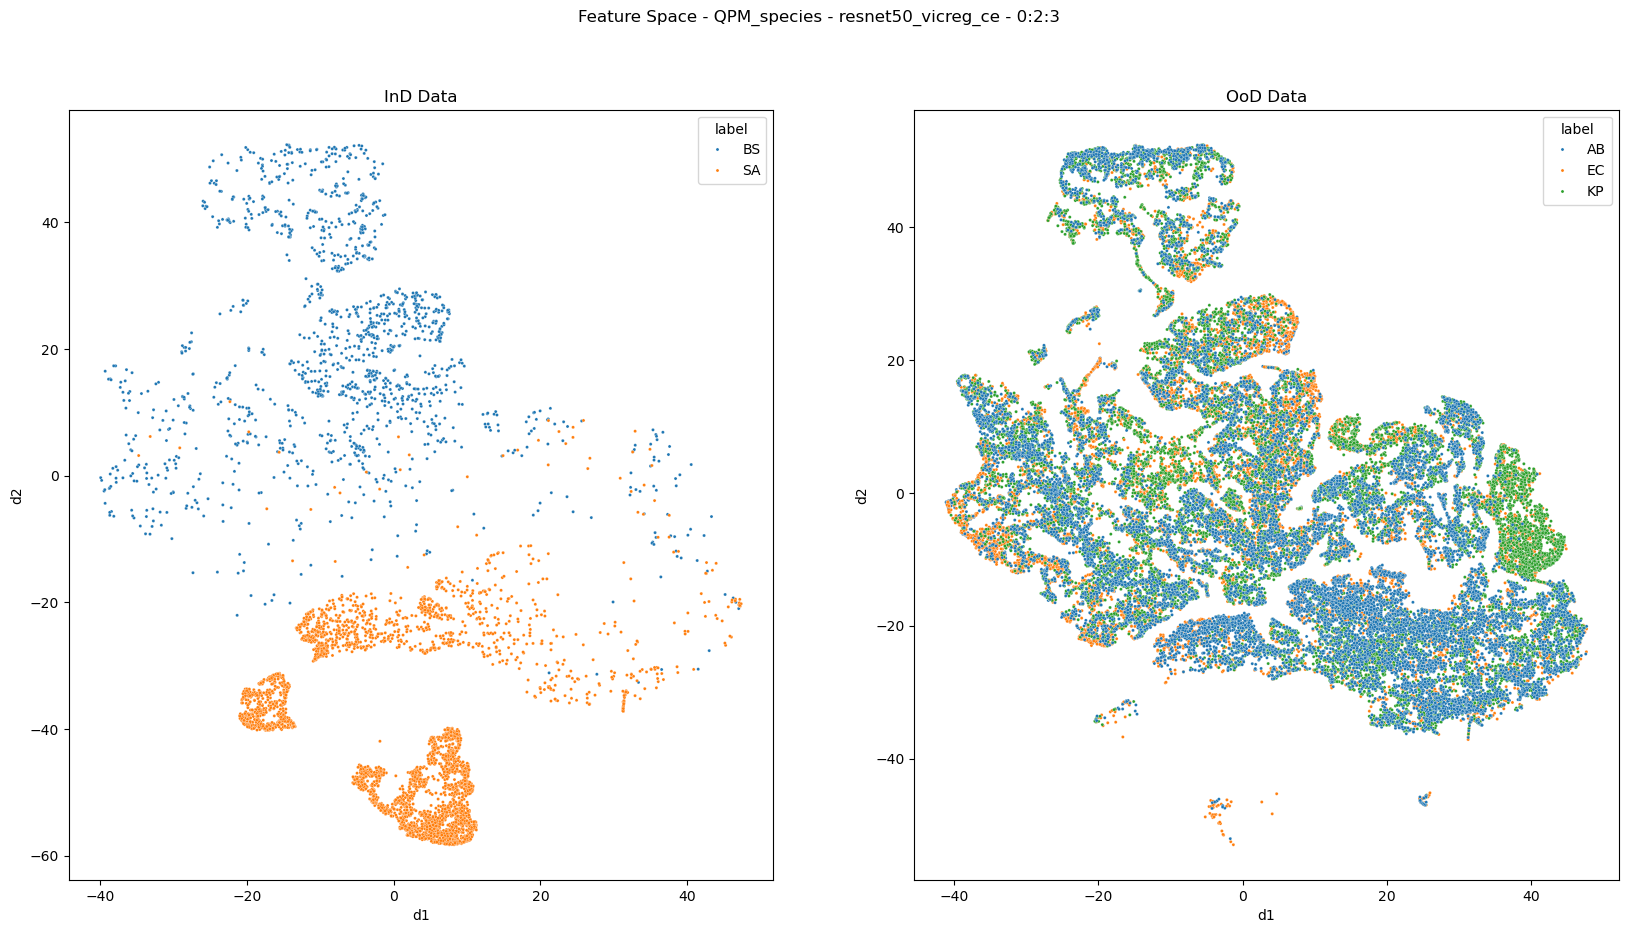

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

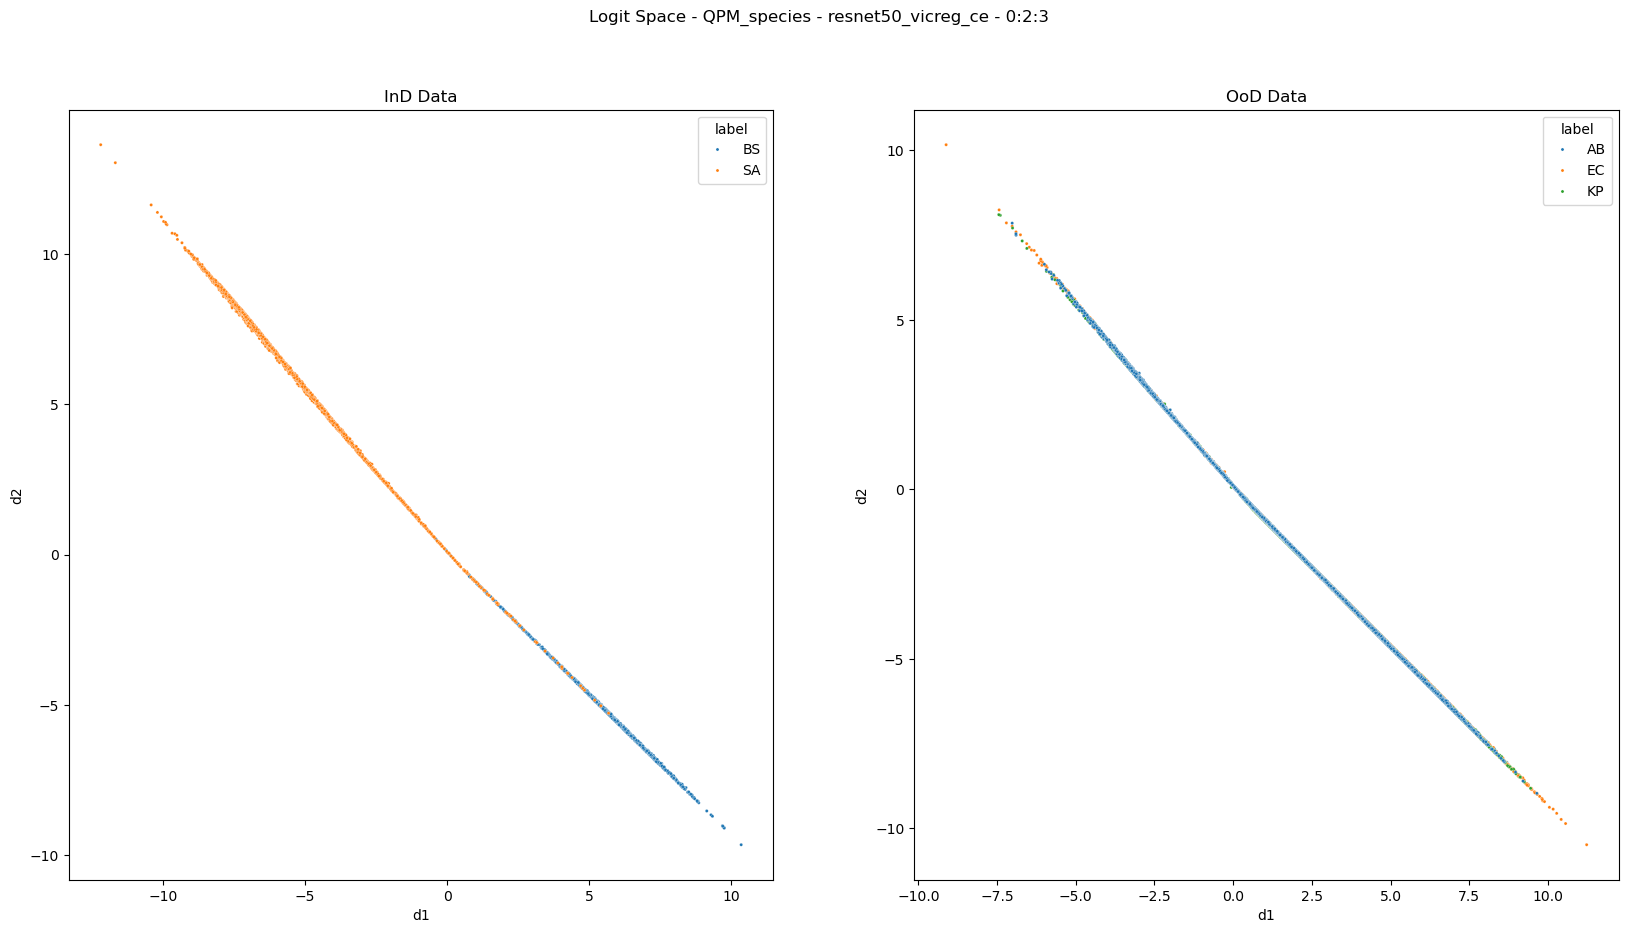

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:07<00:21,  7.07s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:14<00:13,  6.99s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:21<00:07,  7.01s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.08s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.06s/it]

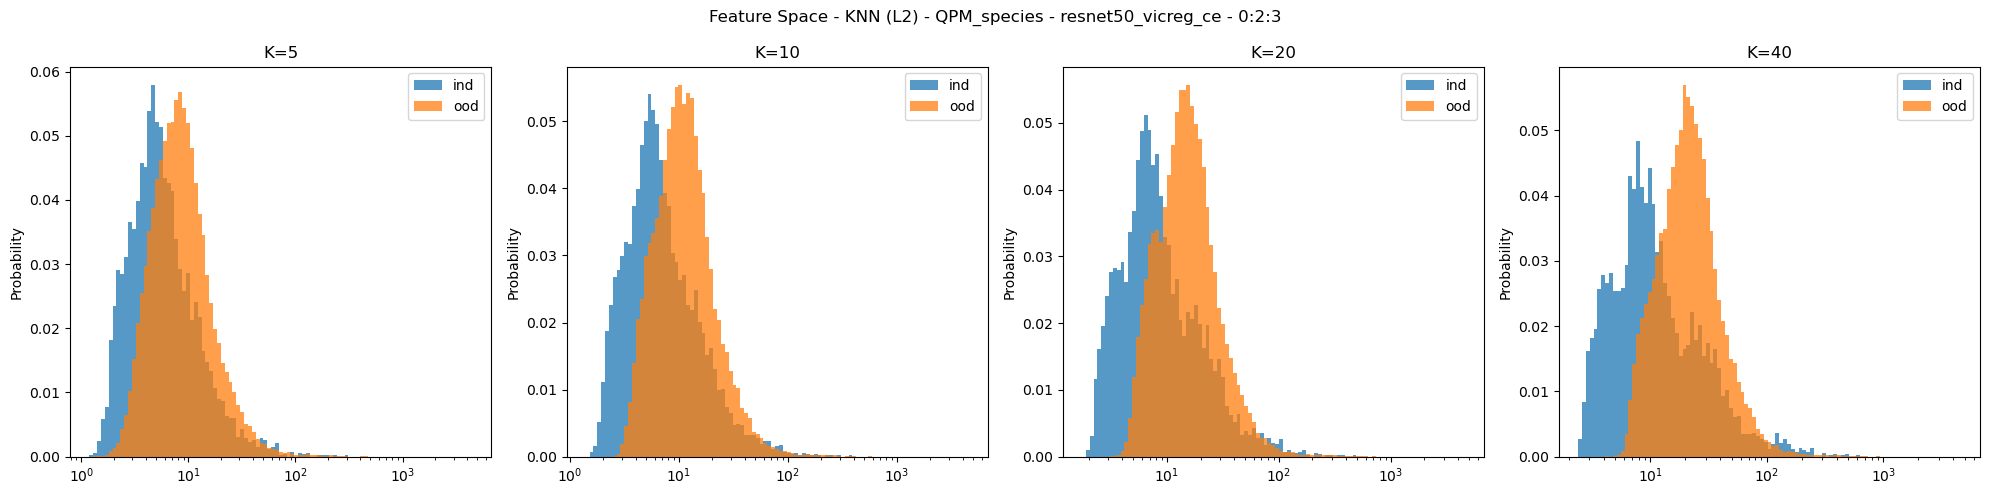

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:06<00:20,  6.81s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:13<00:13,  6.83s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:20<00:06,  6.98s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  7.05s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.99s/it]

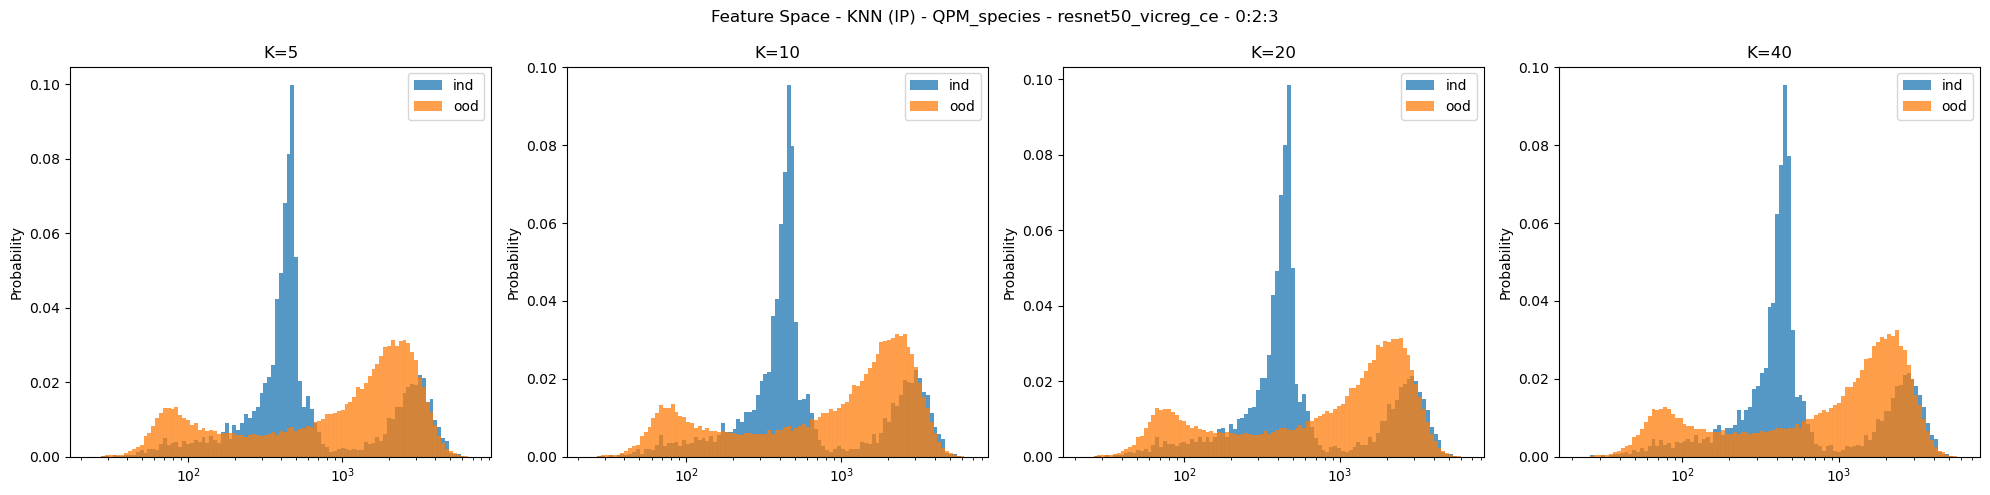

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.57it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.45it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.21it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.87it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]

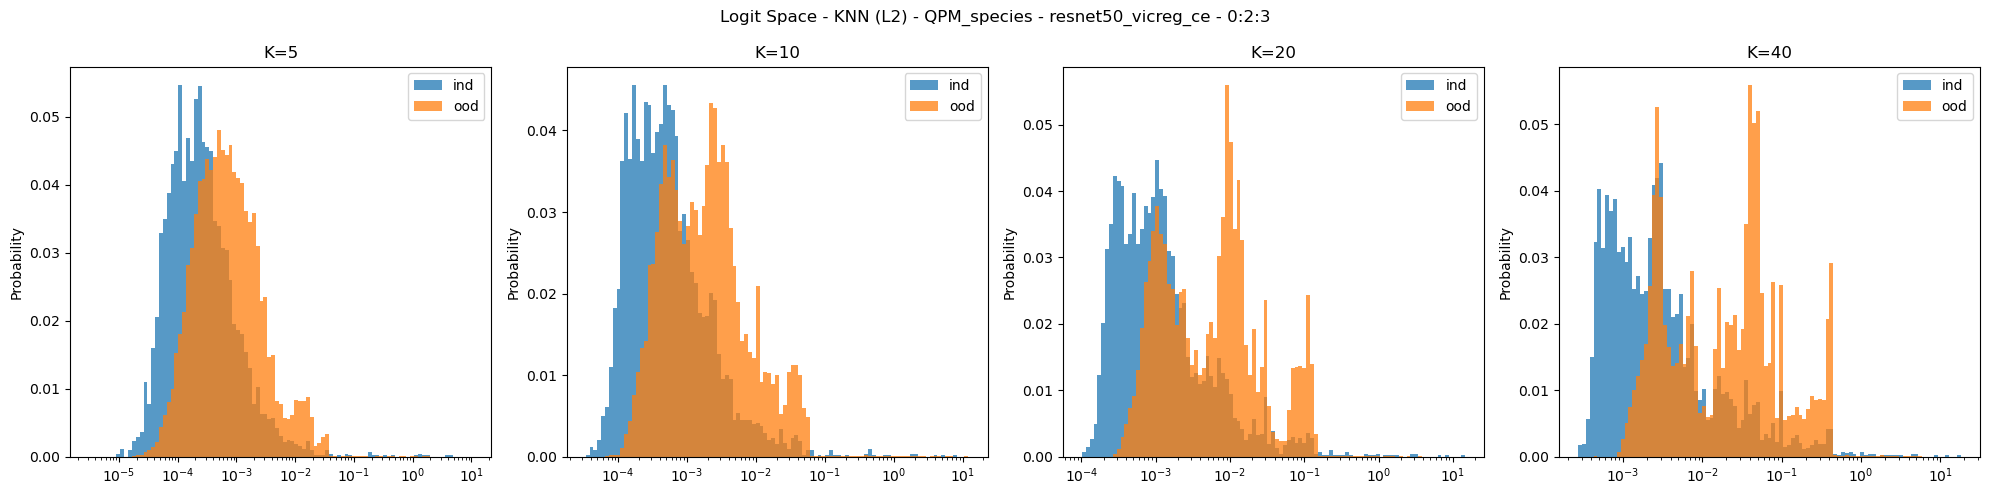

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.90it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.85it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.76it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]

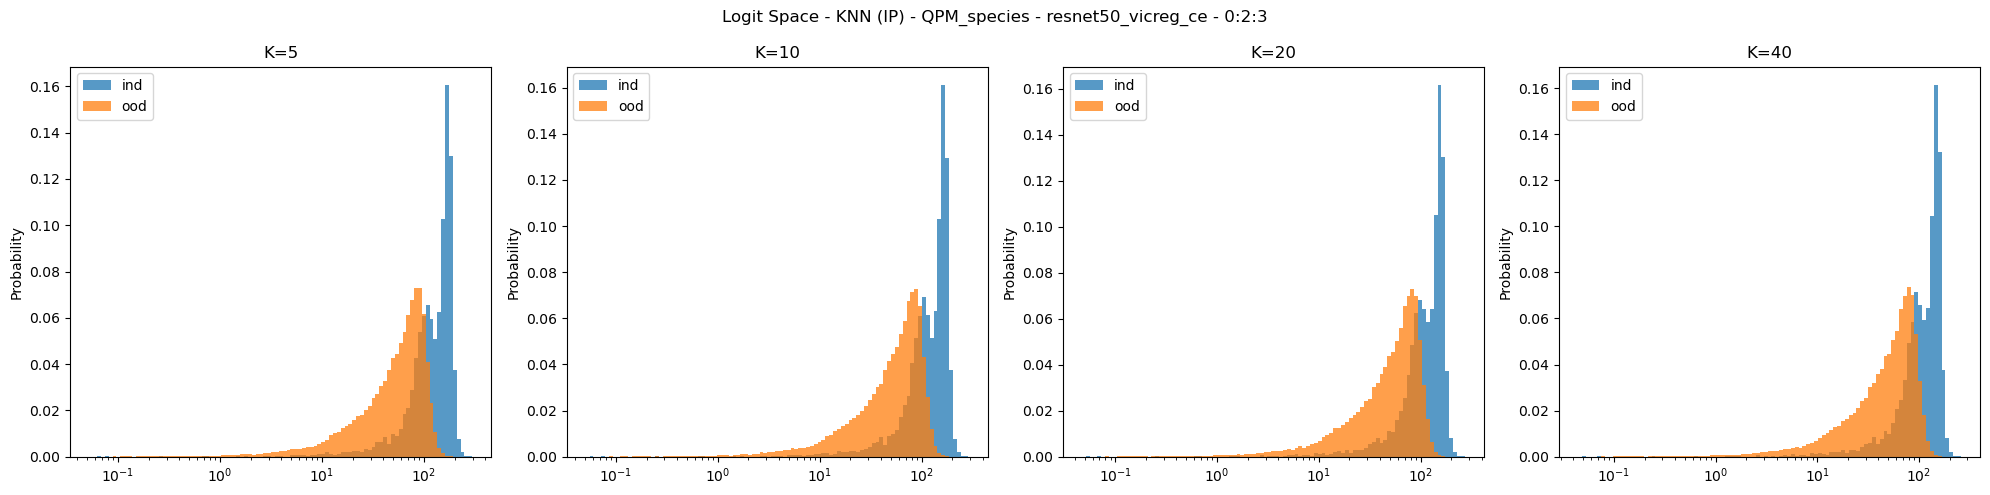

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

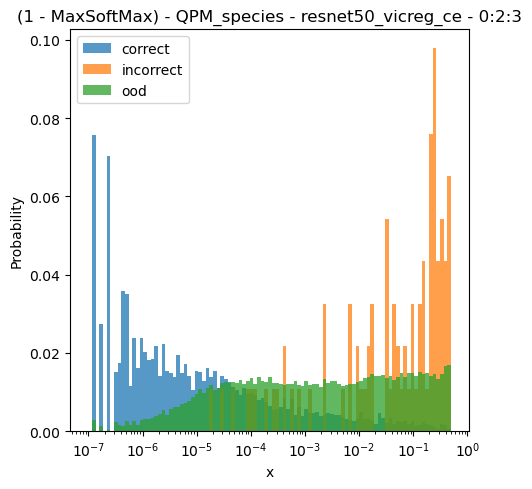

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()